In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout

# from keras import backend as K
from tensorflow import keras

# matplotlib inline
plt.style.use("ggplot")



In [7]:
    filePath = "actitracker_raw.txt"
    columnNames = ["user_id", "activity", "timestamp", "x-axis", "y-axis", "z-axis"]
    dataset = pd.read_csv(filePath, header=None, names=columnNames, na_values=";")


In [9]:
# defining the function to plot a single axis data
def plotAxis(axis, x, y, title):
    axis.plot(x, y)
    axis.set_title(title)
    axis.xaxis.set_visible(False)
    axis.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    axis.set_xlim([min(x), max(x)])
    axis.grid(True)

# defining a function to plot the data for a given activity
def plotActivity(activity, data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15, 10), sharex=True)
    plotAxis(ax0, data["timestamp"], data["x-axis"], "x-axis")
    plotAxis(ax1, data["timestamp"], data["y-axis"], "y-axis")
    plotAxis(ax2, data["timestamp"], data["z-axis"], "z-axis")
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.9)
    plt.show()

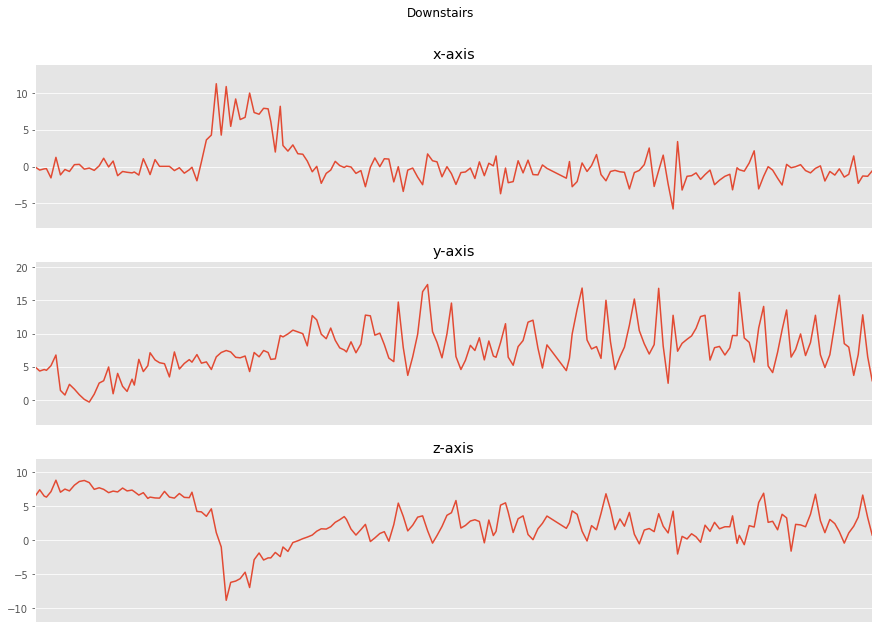

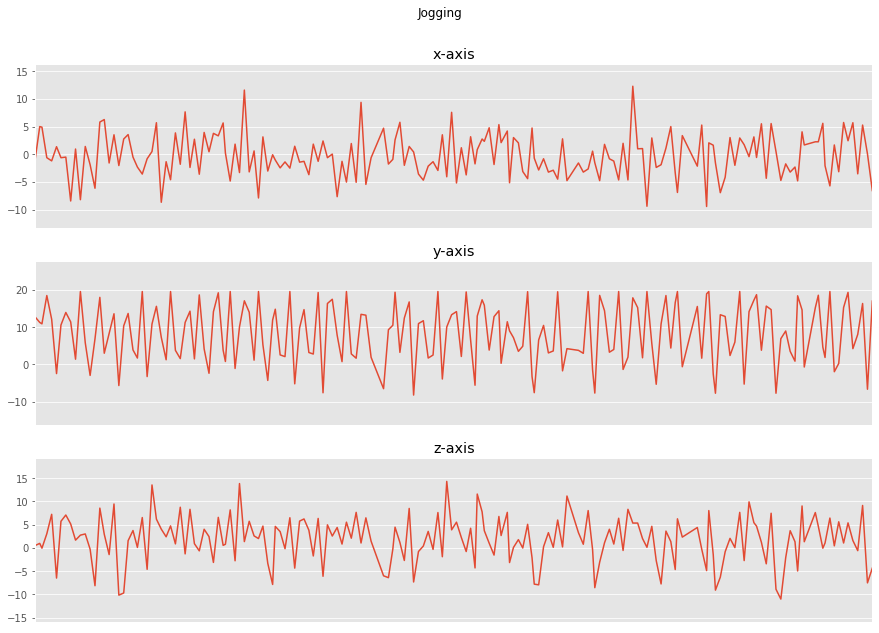

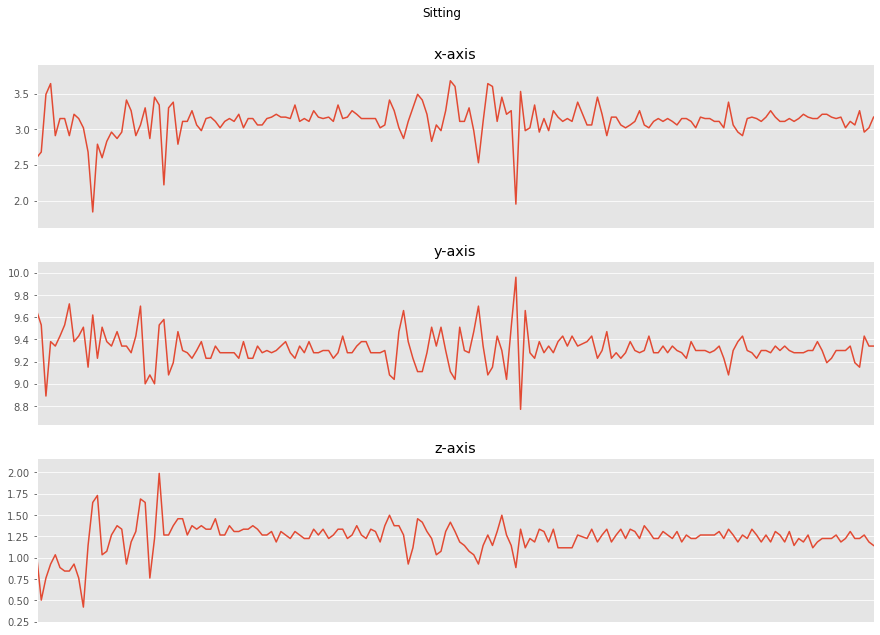

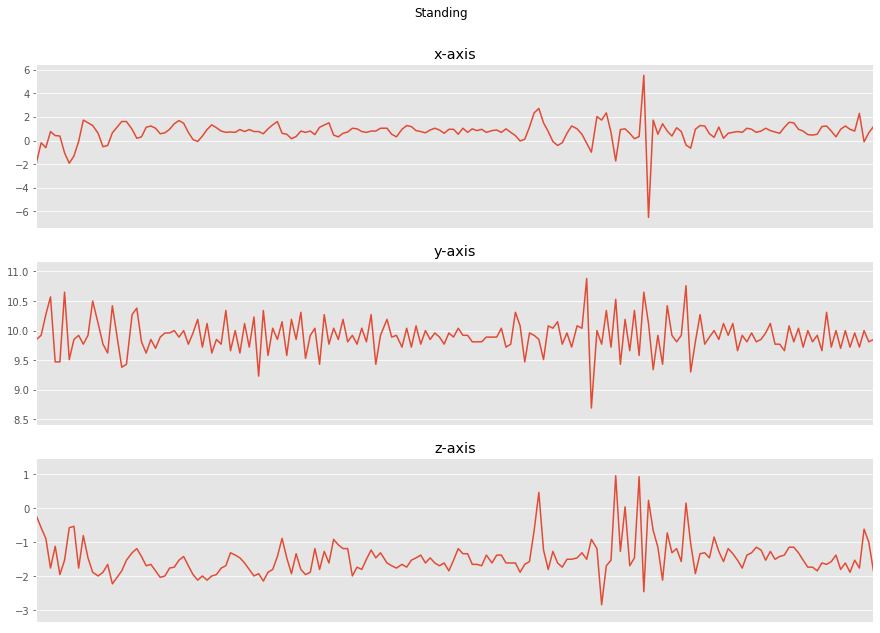

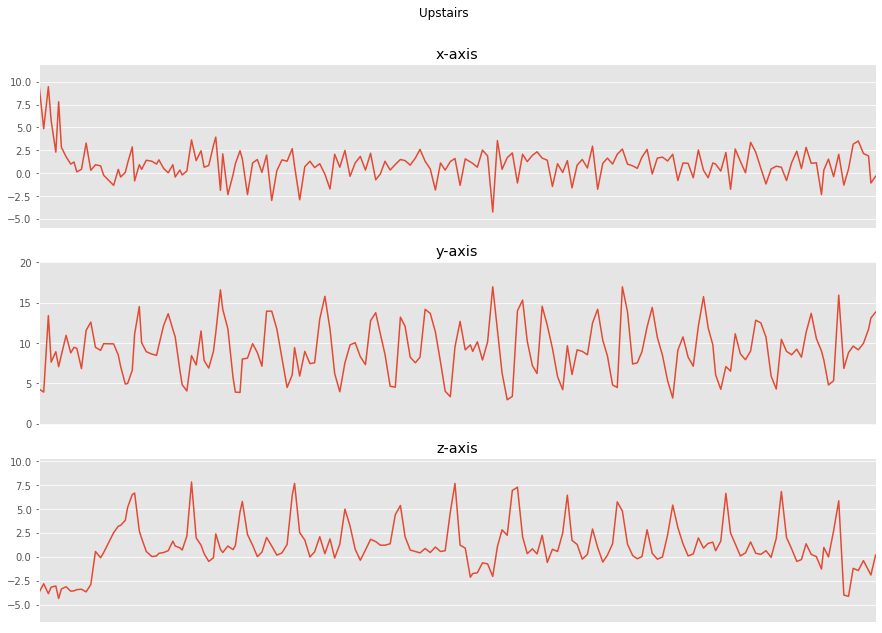

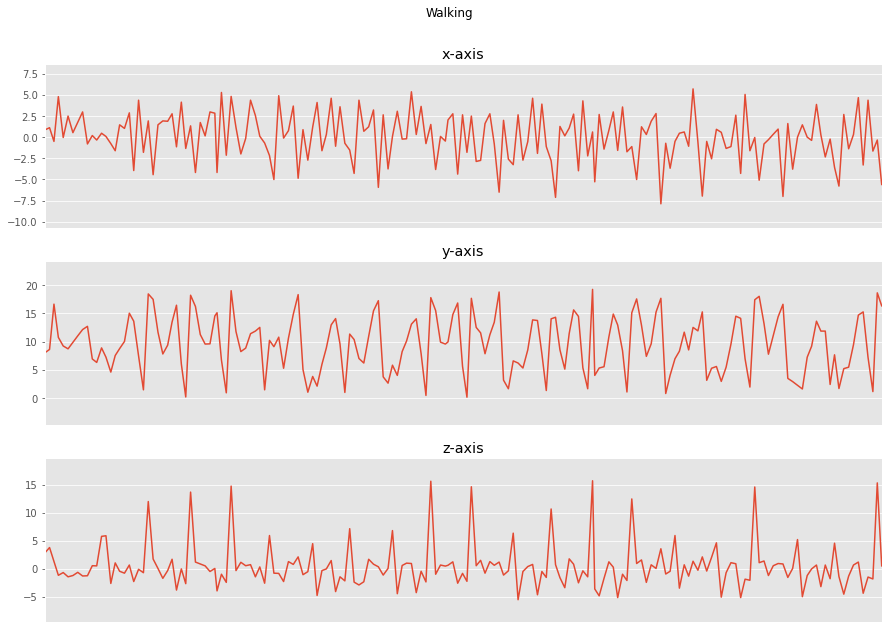

In [14]:
# plotting a subset of the data to visualize
for activity in np.unique(dataset["activity"]):
    subset = dataset[dataset["activity"] == activity][:180]
    plotActivity(activity, subset)

In [17]:
# segmenting the time series
def segment_signal(data, window_size=90):
    segments = np.empty((0, window_size, 3))
    labels = np.empty((0))
    for (start, end) in windows(data["timestamp"], window_size):
        x = data["x-axis"][start:end]
        y = data["y-axis"][start:end]
        z = data["z-axis"][start:end]
        if len(data["timestamp"][start:end]) == window_size:
            segments = np.vstack([segments, np.dstack([x, y, z])])
            labels = np.append(labels, stats.mode(data["activity"][start:end])[0][0])
    return segments, labels

# defining a window function for segmentation purposes
def windows(data, size):
    start = 0
    while start < data.count():
        yield int(start), int(start + size)
        start += size / 2
        
# defining a function for feature normalization
# (feature - mean)/stdiv
def featureNormalize(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset - mu) / sigma

In [18]:
random_seed = 611
np.random.seed(random_seed)



# segmenting the signal in overlapping windows of 90 samples with 50% overlap
segments, labels = segment_signal(dataset)
# categorically defining the classes of the activities
labels = np.asarray(pd.get_dummies(labels), dtype=np.int8)
# defining parameters for the input and network layers
# we are treating each segmeent or chunk as a 2D image (90 X 3)
numOfRows = segments.shape[1]
numOfColumns = segments.shape[2]
numChannels = 1
numFilters = 128  # number of filters in Conv2D layer
# kernal size of the Conv2D layer
kernalSize1 = 2
# max pooling window size
poolingWindowSz = 2
# number of filters in fully connected layers
numNueronsFCL1 = 128
numNueronsFCL2 = 128
# split ratio for test and validation
trainSplitRatio = 0.8
# number of epochs
Epochs = 10
# batchsize
batchSize = 10
# number of total clases
numClasses = labels.shape[1]
# dropout ratio for dropout layer
dropOutRatio = 0.2
# reshaping the data for network input
reshapedSegments = segments.reshape(segments.shape[0], numOfRows, numOfColumns, 1)
# splitting in training and testing data
trainSplit = np.random.rand(len(reshapedSegments)) < trainSplitRatio
trainX = reshapedSegments[trainSplit]
testX = reshapedSegments[~trainSplit]
trainX = np.nan_to_num(trainX)
testX = np.nan_to_num(testX)
trainY = labels[trainSplit]
testY = labels[~trainSplit]

In [ ]:
model = Sequential()
# adding the first convolutionial layer with 32 filters and 5 by 5 kernal size, using the rectifier as the activation function
model.add(
    Conv2D(
        numFilters,
        (kernalSize1, kernalSize1),
        input_shape=(numOfRows, numOfColumns, 1),
        activation="relu",
    )
)
# adding a maxpooling layer
model.add( MaxPooling2D(pool_size=(poolingWindowSz, poolingWindowSz), padding="valid"))
# adding a dropout layer for the regularization and avoiding over fitting
model.add(Dropout(dropOutRatio))
# flattening the output in order to apply the fully connected layer
model.add(Flatten())
# adding first fully connected layer with 256 outputs
model.add(Dense(numNueronsFCL1, activation="relu"))
# adding second fully connected layer 128 outputs
model.add(Dense(numNueronsFCL2, activation="relu"))
# adding softmax layer for the classification
model.add(Dense(numClasses, activation="softmax"))
# Compiling the model to generate a model
adam = keras.optimizers.Adam(learning_rate=0.001, decay=1e-6)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"] )

In [24]:
# Load TensorBoard
%load_ext tensorboard
%tensorboard --logdir logs/scalars

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6007 (pid 4130), started 0:02:17 ago. (Use '!kill 4130' to kill it.)

In [27]:

import datetime
import tensorflow as tf

logdir = "logs/scalars/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

for layer in model.layers:
    print(layer.name)
model.fit(
    trainX,
    trainY,
    validation_split=1 - trainSplitRatio,
    epochs=10,
    batch_size=batchSize,
    verbose=2,
    callbacks=[tensorboard_callback]
)
score = model.evaluate(testX, testY, verbose=2)
print("Baseline Error: %.2f%%" % (100 - score[1] * 100))
model.save("model.h5")
np.save("groundTruth.npy", testY)
np.save("testData.npy", testX)

conv2d
max_pooling2d
dropout
flatten
dense
dense_1
dense_2
Epoch 1/10
1561/1561 - 14s - loss: 0.1961 - accuracy: 0.9300 - val_loss: 0.8201 - val_accuracy: 0.7346
Epoch 2/10
1561/1561 - 14s - loss: 0.1890 - accuracy: 0.9309 - val_loss: 1.4616 - val_accuracy: 0.6564
Epoch 3/10
1561/1561 - 12s - loss: 0.1693 - accuracy: 0.9373 - val_loss: 1.0070 - val_accuracy: 0.7310
Epoch 4/10
1561/1561 - 12s - loss: 0.1641 - accuracy: 0.9415 - val_loss: 1.2653 - val_accuracy: 0.6795
Epoch 5/10
1561/1561 - 11s - loss: 0.1597 - accuracy: 0.9415 - val_loss: 1.2039 - val_accuracy: 0.7115
Epoch 6/10
1561/1561 - 11s - loss: 0.1483 - accuracy: 0.9482 - val_loss: 1.3112 - val_accuracy: 0.7054
Epoch 7/10
1561/1561 - 10s - loss: 0.1414 - accuracy: 0.9490 - val_loss: 1.3158 - val_accuracy: 0.7110
Epoch 8/10
1561/1561 - 11s - loss: 0.1430 - accuracy: 0.9487 - val_loss: 1.1835 - val_accuracy: 0.7259
Epoch 9/10
1561/1561 - 13s - loss: 0.1308 - accuracy: 0.9528 - val_loss: 1.4066 - val_accuracy: 0.7166
Epoch 10/10
15

## Evaluate model

In [28]:
"""
Created on Wed Oct  4 17:07:51 2017
This script is written to evaluate a pretrained model saved as  model.h5 using 'testData.npy' 
and 'groundTruth.npy'. This script reports the error as the cross entropy loss in percentage
and also generated a png file for the confusion matrix. 
@author:Muhammad Shahnawaz
"""
# importing the dependencies
from keras.models import load_model
from sklearn import metrics
import os
# defining a function for plotting the confusion matrix
# takes cmNormalized
os.environ['QT_PLUGIN_PATH'] = ''
def plot_cm(cM, labels,title):
    # normalizing the confusionMatrix for showing the probabilities
    cmNormalized = np.around((cM/cM.sum(axis=1)[:,None])*100,2)
    # creating a figure object
    fig = plt.figure()
    # plotting the confusion matrix
    plt.imshow(cmNormalized,interpolation=None,cmap = plt.cm.Blues)
    # creating a color bar and setting the limits
    plt.colorbar()
    plt.clim(0,100)
    # assiging the title, x and y labels
    plt.xlabel('Predicted Values')
    plt.ylabel('Ground Truth')
    plt.title(title + '\n%age confidence')
    # defining the ticks for the x and y axis
    plt.xticks(range(len(labels)),labels,rotation = 60)
    plt.yticks(range(len(labels)),labels)
    # number of occurences in the boxes
    width, height = cM.shape 
    print('Accuracy for each class is given below.')
    for predicted in range(width):
        for real in range(height):
            color = 'black'
            if(predicted == real):
                color = 'white'
                print(labels[predicted].ljust(12)+ ':', cmNormalized[predicted,real], '%')
            plt.gca().annotate(
                    '{:d}'.format(int(cmNormalized[predicted,real])),xy=(real, predicted),
                    horizontalalignment = 'center',verticalalignment = 'center',color = color)
    # making sure that the figure is not clipped
    plt.tight_layout()
    # saving the figure
    fig.savefig(title +'.png')


153/153 - 1s - loss: 0.5816 - accuracy: 0.8716
Baseline Error: 12.84%
153/153 - 1s
Accuracy for each class is given below.
Downstairs  : 68.51 %
Jogging     : 97.26 %
Sitting     : 93.44 %
Standing    : 93.33 %
Upstairs    : 55.64 %
Walking     : 91.32 %


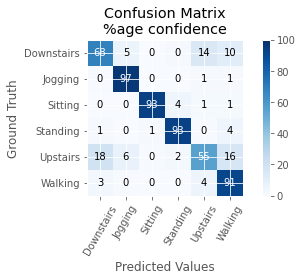

In [29]:
# loading the pretrained model
model = load_model('model.h5')
#loading the testData and groundTruth data
test_x = np.load('testData.npy')
groundTruth = np.load('groundTruth.npy')
# evaluating the model
score = model.evaluate(test_x,groundTruth,verbose=2)
print('Baseline Error: %.2f%%' %(100-score[1]*100))
'''
 Creating and plotting a confusion matrix

'''
# defining the class labels
labels = ['Downstairs','Jogging','Sitting','Standing','Upstairs','Walking']
# predicting the classes
predictions = model.predict(test_x,verbose=2)
# getting the class predicted and class in ground truth for creation of confusion matrix
predictedClass = np.zeros((predictions.shape[0]))
groundTruthClass = np.zeros((groundTruth.shape[0]))
for instance in range (groundTruth.shape[0]):
    predictedClass[instance] = np.argmax(predictions[instance,:])
    groundTruthClass[instance] = np.argmax(groundTruth[instance,:])
# obtaining a confusion matrix  
cm = metrics.confusion_matrix(groundTruthClass,predictedClass)
# plotting the confusion matrix
plot_cm(cm, labels,'Confusion Matrix')

In [32]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("model.tflite", "wb").write(tflite_model)

# Convert the model to the TensorFlow Lite format with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the model to disk
open("model_quantized.tflite", "wb").write(tflite_model)

basic_model_size = os.path.getsize("model.tflite")
print("Basic model is %d bytes" % basic_model_size)
quantized_model_size = os.path.getsize("model_quantized.tflite")
print("Quantized model is %d bytes" % quantized_model_size)
difference = basic_model_size - quantized_model_size
print("Difference is %d bytes" % difference)

INFO:tensorflow:Assets written to: /tmp/tmpflh2twwo/assets
INFO:tensorflow:Assets written to: /tmp/tmp114euifn/assets


INFO:tensorflow:Assets written to: /tmp/tmp114euifn/assets


Basic model is 2958664 bytes
Quantized model is 747104 bytes
Difference is 2211560 bytes


## Create a C source file

The `train.py` script writes a model, `model.tflite`, to the training scripts' directory.

In the following cell, we convert this model into a C++ source file we can use with TensorFlow Lite for Microcontrollers.

In [33]:
# Install xxd if it is not available
!apt-get -qq install xxd
# Save the file as a C source file
!mkdir content
!xxd -i model.tflite > content/model.cc
# Print the source file
!cat content/model.cc

unsigned char model_tflite[] = {
  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00,
  0x04, 0x00, 0x08, 0x00, 0x0c, 0x00, 0x10, 0x00, 0x14, 0x00, 0x00, 0x00,
  0x18, 0x00, 0x1c, 0x00, 0x14, 0x00, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x18, 0x00, 0x00, 0x00, 0x2c, 0x00, 0x00, 0x00, 0xd4, 0x00, 0x00, 0x00,
  0x2c, 0x00, 0x00, 0x00, 0x7c, 0x00, 0x00, 0x00, 0x74, 0x00, 0x00, 0x00,
  0x05, 0x00, 0x00, 0x00, 0x1c, 0x06, 0x00, 0x00, 0x38, 0x05, 0x00, 0x00,
  0x70, 0x04, 0x00, 0x00, 0xac, 0x03, 0x00, 0x00, 0xa0, 0x01, 0x00, 0x00,
  0x01, 0x00, 0x00, 0x00, 0xcc, 0x00, 0x00, 0x00, 0x13, 0x00, 0x00, 0x00,
  0xe4, 0x24, 0x2d, 0x00, 0xe0, 0x24, 0x2d, 0x00, 0xc4, 0x21, 0x2d, 0x00,
  0x5c, 0x19, 0x2d, 0x00, 0xf4, 0x16, 0x2d, 0x00, 0x8c, 0x14, 0x2d, 0x00,
  0x0c, 0x14, 0x2d, 0x00, 0xa0, 0x13, 0x2d, 0x00, 0x50, 0x13, 0x01, 0x00,
  0xfc, 0x12, 0x00, 0x00, 0xa8, 0x06, 0x00, 0x00, 0xb8, 0x24, 0x2d, 0x00,
  0xb4, 0x24, 0x2d, 0x00, 0xb0, 0x24, 0x2d, 0x00, 0xac, 0x24, 0x2d, 0x00,
  0xa

  0x52, 0xf9, 0x00, 0xbd, 0xc4, 0x72, 0x7c, 0xbb, 0x49, 0xe9, 0xad, 0x3d,
  0xec, 0x04, 0xec, 0xbb, 0x5b, 0xa7, 0x74, 0x3d, 0xa2, 0x68, 0x3c, 0x3b,
  0x01, 0x26, 0xe4, 0x3d, 0x03, 0x25, 0xbd, 0x3d, 0xcd, 0xc8, 0xc6, 0xbe,
  0x38, 0x87, 0xce, 0x3d, 0x32, 0xb6, 0x69, 0xbe, 0xdd, 0xf9, 0x60, 0xbe,
  0xea, 0x26, 0x0c, 0x3d, 0xd3, 0x09, 0x7a, 0x3e, 0x5b, 0x7a, 0x18, 0x3d,
  0x61, 0x32, 0x2f, 0xbe, 0x11, 0x10, 0xa2, 0x3d, 0xaa, 0x22, 0xbb, 0xbd,
  0xfd, 0x9c, 0xed, 0x3d, 0x96, 0x33, 0x8c, 0x3d, 0x71, 0xbd, 0x3f, 0x3e,
  0x8b, 0xa3, 0x83, 0x3d, 0xe0, 0x0f, 0x67, 0x3e, 0x59, 0xfe, 0x27, 0xbe,
  0x34, 0x84, 0xac, 0x3c, 0x82, 0xa2, 0x8c, 0xbc, 0xd4, 0x94, 0xcd, 0x3d,
  0xfa, 0x76, 0x42, 0x3e, 0xa5, 0x82, 0x5c, 0xbe, 0xa8, 0x9b, 0x09, 0xbe,
  0x79, 0xd3, 0xa8, 0xbe, 0xcc, 0x67, 0xca, 0x3d, 0x5e, 0x81, 0x4e, 0x3d,
  0xab, 0xe8, 0x0e, 0x3e, 0xe8, 0x25, 0x9f, 0xbe, 0xfb, 0xa2, 0x32, 0x3d,
  0x3d, 0xff, 0x81, 0x3d, 0x78, 0x4a, 0x2e, 0x3d, 0x41, 0x1b, 0xcf, 0x3b,
  0x89, 0x7c, 0x48, 0xbd, 0xac, 0x6e, 

  0x5c, 0x62, 0x0b, 0xbc, 0xd0, 0x8e, 0x53, 0x3c, 0xfa, 0x93, 0xde, 0xbc,
  0xf6, 0x31, 0xc4, 0xbc, 0x18, 0x4f, 0x91, 0xba, 0x50, 0xb3, 0x6b, 0x3c,
  0xc6, 0x41, 0xf1, 0x3c, 0x05, 0x34, 0xb6, 0xbb, 0x4e, 0xc8, 0x07, 0xbb,
  0x01, 0x7a, 0xa2, 0x3c, 0x69, 0xe9, 0x22, 0x3c, 0x4c, 0xfd, 0xe5, 0xbb,
  0xef, 0xce, 0x79, 0xbc, 0x0e, 0xfd, 0x20, 0x3c, 0x16, 0xe2, 0xc9, 0x3c,
  0xb0, 0x8f, 0x60, 0x3c, 0xc6, 0x78, 0xf6, 0xbc, 0x4f, 0x69, 0x16, 0xbd,
  0xa3, 0xde, 0xb0, 0x3b, 0x39, 0x7b, 0x4a, 0x3c, 0x04, 0x82, 0x61, 0xbb,
  0xe6, 0xf3, 0x3f, 0xbc, 0x8a, 0x38, 0xc4, 0xbc, 0xdd, 0x2f, 0x9e, 0x3c,
  0x70, 0xda, 0x31, 0x3c, 0x31, 0x64, 0x0f, 0xbd, 0x26, 0x44, 0xe3, 0xbc,
  0x89, 0x46, 0x35, 0xbc, 0xb4, 0x49, 0xd9, 0xbc, 0xc1, 0x20, 0x8f, 0x3a,
  0xe2, 0xc0, 0x19, 0xbd, 0x21, 0xf5, 0xaa, 0xbc, 0x79, 0x99, 0xae, 0xbb,
  0x16, 0x85, 0xba, 0x3a, 0x30, 0xd9, 0xf5, 0xbc, 0x9a, 0x1c, 0x27, 0xba,
  0xa9, 0xd2, 0xf9, 0xbb, 0x26, 0xfb, 0xa6, 0x3c, 0xea, 0xea, 0x19, 0xbd,
  0xb6, 0x17, 0xfa, 0x3c, 0xd4, 0x44, 

  0x53, 0xeb, 0xe9, 0xbc, 0xaa, 0x44, 0xe6, 0x3c, 0x70, 0x60, 0x1e, 0x3b,
  0x3a, 0xf5, 0xb9, 0x3b, 0xad, 0x93, 0xf3, 0xbc, 0xc4, 0x01, 0x73, 0x3c,
  0xfd, 0xa0, 0x0b, 0xbd, 0x11, 0x37, 0x8a, 0x3c, 0x9e, 0xe1, 0x69, 0x3c,
  0xb6, 0x9f, 0xb0, 0xbc, 0xac, 0x88, 0xae, 0x3c, 0x48, 0xec, 0xb0, 0x3c,
  0x08, 0x23, 0x95, 0x3b, 0xfe, 0x8d, 0xb6, 0x3c, 0x8a, 0x5e, 0xcd, 0x3c,
  0xc0, 0xb4, 0x1c, 0xbb, 0x58, 0x69, 0xec, 0xbc, 0x70, 0x23, 0x89, 0xbb,
  0xd0, 0xe5, 0x41, 0x3b, 0x5e, 0xa0, 0x98, 0xbc, 0x42, 0xf9, 0x31, 0x3c,
  0x18, 0xc2, 0xb0, 0x3c, 0x53, 0x91, 0xb5, 0x3c, 0xfa, 0xc7, 0xfd, 0x3b,
  0xc2, 0x25, 0x45, 0xbc, 0xbc, 0x84, 0xee, 0xbc, 0xe0, 0x56, 0xf9, 0x3a,
  0x0d, 0xa0, 0xab, 0xbc, 0xb4, 0x86, 0x85, 0xbc, 0xfe, 0x05, 0x9f, 0xbc,
  0xa8, 0x86, 0xaa, 0x3b, 0x6f, 0x56, 0xf5, 0xbb, 0x30, 0x2a, 0x19, 0x3c,
  0x26, 0xd6, 0x41, 0xbc, 0x64, 0x81, 0xee, 0x3b, 0xc3, 0xaf, 0x85, 0xbc,
  0x78, 0x64, 0x23, 0xbb, 0x04, 0xf7, 0x43, 0x3c, 0xc3, 0x5c, 0xce, 0x3c,
  0xee, 0x3e, 0x5a, 0x3c, 0x73, 0xbd, 

  0x67, 0xef, 0xfc, 0x3c, 0x7e, 0x4e, 0x31, 0x3d, 0x58, 0x83, 0x9a, 0x3c,
  0x81, 0xcd, 0x1c, 0xbd, 0xa6, 0x78, 0x60, 0xbc, 0xc7, 0xed, 0x3e, 0x3d,
  0x2e, 0xa4, 0x9a, 0x3b, 0x3e, 0xf1, 0x2a, 0xbd, 0xc3, 0x58, 0xeb, 0x3c,
  0x95, 0x7e, 0x29, 0x3c, 0xe1, 0x48, 0x9e, 0xbc, 0xb8, 0xb8, 0xbd, 0xba,
  0xe2, 0x15, 0x35, 0xbc, 0xd2, 0x0c, 0x3b, 0xbc, 0xc2, 0x0d, 0x78, 0xbb,
  0x2e, 0xf5, 0x22, 0xbc, 0xf5, 0x8e, 0x22, 0xbd, 0xe5, 0xd8, 0xa2, 0x3c,
  0x6c, 0xac, 0xcf, 0xbc, 0x03, 0x56, 0x3c, 0xbc, 0x7e, 0x48, 0xed, 0x3c,
  0x66, 0x49, 0x8b, 0x3c, 0xc4, 0x45, 0x16, 0x3d, 0xa7, 0x37, 0xcf, 0xbc,
  0x5b, 0x79, 0x8c, 0x3c, 0xad, 0xef, 0x18, 0xbd, 0x64, 0x4a, 0xd1, 0xbc,
  0x1c, 0xe9, 0xc3, 0x3c, 0x26, 0x26, 0xb7, 0xbc, 0xa5, 0x59, 0x7d, 0xba,
  0xe5, 0x06, 0x41, 0x3c, 0xa3, 0xb8, 0xc9, 0x3c, 0xa8, 0x92, 0xe5, 0x3b,
  0x58, 0x72, 0x8a, 0xbc, 0x21, 0x66, 0x12, 0xbd, 0xde, 0xb4, 0x7a, 0x3d,
  0x66, 0xc4, 0x9a, 0x3c, 0xa8, 0xbf, 0x79, 0xbc, 0x62, 0x36, 0xfa, 0xba,
  0x60, 0x48, 0x1c, 0x3c, 0x70, 0x05, 

  0x29, 0x2d, 0x40, 0xbc, 0x56, 0xd4, 0x05, 0xbd, 0x81, 0x3d, 0x7b, 0x3c,
  0xa0, 0xa5, 0xf9, 0xbc, 0x98, 0x6d, 0xd7, 0xbc, 0x07, 0x99, 0x11, 0xbc,
  0x46, 0x0d, 0x22, 0x3c, 0xf7, 0x1f, 0xf8, 0xbc, 0xac, 0x64, 0xc6, 0x3c,
  0xa8, 0xd0, 0xcc, 0xbc, 0xc8, 0xd9, 0x8c, 0xbc, 0xa2, 0xc6, 0x04, 0xbb,
  0x89, 0xe2, 0x96, 0x3b, 0x1c, 0x50, 0x5f, 0x3c, 0x95, 0x4d, 0xd5, 0xbc,
  0xac, 0xaa, 0x8b, 0xbb, 0xae, 0x24, 0x1f, 0xbc, 0x51, 0xcc, 0x83, 0x3b,
  0x87, 0x3c, 0x0c, 0xbb, 0xec, 0x5f, 0x2c, 0xbc, 0x7b, 0x8d, 0x5e, 0xbc,
  0x03, 0xd3, 0x4e, 0x3c, 0x8f, 0x7d, 0x9e, 0xbb, 0x62, 0x31, 0xa8, 0x3c,
  0xc1, 0x0d, 0xd0, 0xbb, 0x68, 0xc6, 0xbb, 0x3c, 0x59, 0x55, 0x10, 0xbd,
  0x04, 0x61, 0x15, 0xbd, 0x43, 0x36, 0x0f, 0x3c, 0x20, 0x39, 0xdb, 0xbc,
  0xb6, 0xd1, 0xa1, 0x3c, 0x80, 0x5f, 0xc9, 0x3c, 0xc2, 0x10, 0x72, 0xbc,
  0x74, 0xf3, 0x2d, 0xbc, 0x01, 0x4f, 0x01, 0xbd, 0x9e, 0xfa, 0xdc, 0x3b,
  0x82, 0xa2, 0x19, 0xbd, 0x7c, 0x84, 0xa9, 0xbc, 0x33, 0x8a, 0xc3, 0x3b,
  0xc2, 0xbe, 0xcf, 0x3b, 0xc8, 0x0f, 

  0x04, 0xc7, 0xc8, 0x3c, 0x79, 0x63, 0x82, 0x3c, 0x2d, 0x08, 0xfe, 0xbc,
  0x5e, 0x30, 0x0b, 0xbd, 0x22, 0x1b, 0x83, 0x3b, 0x7f, 0x91, 0xb3, 0x3c,
  0x16, 0x5f, 0xb2, 0x3c, 0x0b, 0x9e, 0x70, 0x3c, 0xa5, 0x66, 0x8c, 0x3b,
  0x8a, 0x31, 0x66, 0xbc, 0x2d, 0x8e, 0x94, 0x3a, 0x45, 0x8a, 0xc7, 0xbc,
  0xc0, 0x8e, 0x0d, 0x3b, 0x53, 0xff, 0x08, 0xbd, 0x5a, 0x38, 0xce, 0x3b,
  0x62, 0xb9, 0x26, 0x3c, 0x89, 0xc2, 0x9c, 0xbc, 0xae, 0x41, 0xbd, 0xbc,
  0xa3, 0x9a, 0x8d, 0x3c, 0x67, 0xd0, 0x82, 0xbc, 0xf6, 0x20, 0xe1, 0xbc,
  0xc0, 0xa2, 0x18, 0x3a, 0x34, 0x56, 0x66, 0xbc, 0xae, 0xcc, 0xdd, 0xbc,
  0xbe, 0x98, 0xf3, 0xbc, 0x8e, 0x56, 0x54, 0x3c, 0x31, 0x85, 0x7d, 0xbc,
  0xf4, 0x9b, 0xa1, 0x3c, 0x7c, 0x41, 0xd3, 0x3b, 0xfe, 0x83, 0x8b, 0xbc,
  0x73, 0xed, 0x23, 0x3c, 0x7f, 0xae, 0x0f, 0xbc, 0xe4, 0x34, 0xbe, 0x3c,
  0x6d, 0xea, 0xa6, 0x3c, 0xb7, 0x54, 0x8d, 0xbc, 0x27, 0x9b, 0x13, 0xbd,
  0x9e, 0xce, 0x28, 0xbc, 0x25, 0x85, 0x85, 0xbc, 0x94, 0x5d, 0xf8, 0x3b,
  0x8a, 0x8f, 0x6d, 0xbc, 0x49, 0x9f, 

  0x31, 0x08, 0x1b, 0xbc, 0x7a, 0x8a, 0x9d, 0xbc, 0xeb, 0x62, 0xb6, 0xbc,
  0xd9, 0x50, 0x03, 0x3b, 0x98, 0x62, 0x70, 0x3c, 0xc1, 0x85, 0xc0, 0x3b,
  0x6d, 0xf9, 0x04, 0xbd, 0xf8, 0x47, 0x88, 0x3c, 0x7e, 0x14, 0x10, 0xbd,
  0x50, 0xdf, 0x69, 0xbb, 0x55, 0xd9, 0x93, 0xbc, 0xc5, 0x5e, 0x87, 0xbb,
  0xb2, 0x06, 0x71, 0xbc, 0xbd, 0x9b, 0x4e, 0x3c, 0xc3, 0x5a, 0xc0, 0x3c,
  0x33, 0x1f, 0x9d, 0xbc, 0x20, 0x11, 0xdb, 0x3b, 0x98, 0x07, 0xa0, 0xbc,
  0xbc, 0x28, 0x8e, 0xbc, 0xb0, 0x9a, 0xcc, 0x3c, 0x47, 0xd8, 0xc7, 0xbc,
  0xe7, 0x12, 0xf0, 0xb9, 0x6a, 0x23, 0x31, 0xbc, 0xdb, 0xb7, 0x61, 0xbc,
  0x09, 0x7e, 0x8e, 0xbc, 0x09, 0x6a, 0x4d, 0xbc, 0xc0, 0x7d, 0x9e, 0x3c,
  0xea, 0x21, 0x14, 0xbc, 0xa9, 0xd1, 0x4f, 0xbc, 0x3c, 0xbb, 0x06, 0xbd,
  0x44, 0x94, 0x8d, 0x3c, 0x8d, 0xdb, 0xc0, 0xbc, 0x70, 0xd8, 0x78, 0xbc,
  0x81, 0xf8, 0xc0, 0x3c, 0x0f, 0x82, 0x8a, 0x3c, 0x7f, 0x58, 0x00, 0xbd,
  0x19, 0x4b, 0x1b, 0xbb, 0x43, 0x2f, 0x2a, 0xbc, 0xed, 0x2b, 0x82, 0x3c,
  0xce, 0x82, 0xe2, 0xbc, 0x04, 0x15, 

  0x41, 0x64, 0xb2, 0xbc, 0xfa, 0x77, 0xd8, 0x3a, 0xb8, 0x1f, 0x1c, 0xbd,
  0xfa, 0x92, 0x0d, 0xbd, 0x19, 0x28, 0xc0, 0xbc, 0xbe, 0x80, 0x76, 0xbc,
  0x7c, 0x88, 0x18, 0xbb, 0x8d, 0x4f, 0x2b, 0xbc, 0x57, 0x10, 0xe9, 0xbc,
  0x04, 0x53, 0x6d, 0xbb, 0xe4, 0xc2, 0xff, 0xbb, 0x21, 0xca, 0x1e, 0x3c,
  0x4f, 0xa5, 0x2f, 0x3a, 0xa6, 0x19, 0xe3, 0x3b, 0x63, 0x15, 0x00, 0x3c,
  0x09, 0x14, 0xa6, 0x3c, 0x49, 0x6e, 0x27, 0xbc, 0xe7, 0xa1, 0xc5, 0xbc,
  0xf9, 0x92, 0xba, 0xbc, 0xf3, 0x33, 0x47, 0x3c, 0x9d, 0x6e, 0x0f, 0x3d,
  0x65, 0x7e, 0x32, 0x3c, 0xfa, 0x20, 0xe3, 0xbc, 0x39, 0xcd, 0x0f, 0x3c,
  0x6e, 0x64, 0xa4, 0x3c, 0xc6, 0xee, 0x4a, 0xbc, 0xde, 0xa1, 0x09, 0xbd,
  0xc1, 0x39, 0xd7, 0xbb, 0x18, 0xb3, 0xfc, 0xbc, 0x00, 0x53, 0x44, 0xbc,
  0x50, 0x14, 0xcb, 0x3a, 0x83, 0xb7, 0x62, 0xbb, 0x13, 0x8d, 0x6f, 0x3a,
  0x92, 0xb2, 0xb3, 0x3c, 0xb7, 0x5a, 0x48, 0x3b, 0x0c, 0x54, 0x9f, 0xbc,
  0x98, 0xf7, 0x21, 0xbd, 0x8e, 0xf3, 0x5e, 0xbb, 0x8a, 0x88, 0x4c, 0x3b,
  0xed, 0x71, 0xe8, 0xbc, 0x56, 0xb1, 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

